In [1]:
import numpy as np
import pandas as pd
import glob
from scipy import stats
from pandasql import sqldf as sql

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from statannotations.Annotator import Annotator
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

### Functions 

In [2]:
def outliers_z_score_mod(data: pd.DataFrame,
                         feature: str, 
                         log_scale=False, 
                         left=3, 
                         right=3) -> tuple[pd.DataFrame]:
    """
    Function calculates outliers based on 3-sigma rule.

    :param data: dataset
    :param feature: column to be analyzed
    :param log_scale: log transformation of column
    :left: size of left tail
    :right: size of right tail
    :return: two datasets (with outliers and remain data)
    """
    if log_scale:
        x = np.log(abs(data[feature]) + 1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left*sigma
    upper_bound = mu + right*sigma
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]

    return outliers, cleaned

In [3]:
def check_normality(feature1: pd.Series, 
                    feature2: pd.Series, 
                    title1: str, 
                    title2: str) -> None:
    """
    Function prints histograms with kernel density function,
    QQ-plot and performs Shapiro-Wilk test for normality.

    :param feature1: 1st target feature
    :param feature2: 2nd target feature
    :param title1: title for 1st feature plot
    :param title2: title for 2nd feature plot
    :return: None 
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    sns.histplot(feature1, ax=axes[0][0], kde=True)
    sns.histplot(feature2, ax=axes[1][0], kde=True)
    axes[0][0].set_title(title1)
    axes[1][0].set_title(title2)
    stats.probplot(feature1, dist="norm", plot=axes[0][1])
    stats.probplot(feature2, dist="norm", plot=axes[1][1])

    print(f'Shapiro Test for 1st feature: p = {stats.shapiro(feature1)[1]}')
    print(f'Shapiro Test for 2nd feature: p = {stats.shapiro(feature2)[1]}')

In [4]:
def boxplot_stats(feature1: pd.Series,
                  feature2: pd.Series,
                  x_label1: str,
                  x_label2: str, 
                  set_x: str, 
                  set_y: str,
                  alternative: str, 
                  notch: bool=False) -> None:
    """
    Function prints boxplot for 2 features and performs
    hypothesis testing with non parametric U-test.

    :param feature1: 1st target feature
    :param feature2: 2nd target feature
    :param x_label1: title for 1st feature
    :param x_label2: title for 2nd feature
    :param set_x: x labels
    :param set_y: y labels
    :param alternative: 'greater', 'less' or 'two-sided'
    :param notch: notch at box plot, default False
    :return: None 
    """
    plt.figure(figsize=(8, 6))
    df = [feature1, feature2]
    ax = sns.boxplot(data=df, notch=notch)
    ax.set_xlabel(set_x)
    ax.set_ylabel(set_y)
    ax.set_xticklabels([x_label1, x_label2])
    annotator = Annotator(ax, [(0, 1)], data=df)
    annotator.configure(
        test='Mann-Whitney', 
        text_format='full', 
        loc='inside'
    )
    annotator.apply_test(alternative=alternative)
    annotator.annotate();

    p = stats.mannwhitneyu(feature1, feature2, alternative=alternative)[1]
    print(f'\nMann-Whitney test:\n H1 = {alternative}, p = {p}')

In [5]:
def win_loss_prep(data: pd.DataFrame, 
                  name: str) -> tuple[pd.DataFrame]:
    """
    Function collects statistics on wins and losses of a given player.

    :param data: dataset
    :param name: player's name who is needed to be analyzed
    :return: tuple of two datasets (wins and losses)
    """
    # Filtering data on a given player
    player = data.loc[
        (data['winner_name'] == name) | (data['loser_name'] == name)
    ].copy()

    # Dividing dataset for wins data and losses data
    df_win = player.loc[player['winner_name'] == name].copy()
    df_loss = player.loc[player['loser_name'] == name].copy()

    # List of years in dataset
    years_w = sorted(list(set(df_win['year'])))
    years_l = sorted(list(set(df_loss['year'])))

    # Visualising data to choose time period for analysis
    annualwin = df_win.groupby(df_win['year']).count().tourney_id
    annualloss = df_loss.groupby(df_loss['year']).count().tourney_id
    fig, ax = plt.subplots()
    ax.plot(years_w, annualwin, label='Win')
    ax.plot(years_l, annualloss, label='Loss')
    ax.set_title(f'Wins and losses of {name}')
    ax.set_xlabel('Time period, years')
    ax.set_ylabel('Mean number of wins/losses')
    plt.xticks(np.arange(1998, 2024, 2), rotation=45)
    ax.legend()

    return df_win, df_loss

In [6]:
def win_loss_modif(df_win: pd.DataFrame,
                   df_loss: pd.DataFrame,
                   y_low: int,
                   y_up: int) -> pd.DataFrame:
    """
    Function collects statistics on winning breakpoints.

    :param df_win: dataset containing statistics on wins
    :param df_loss: dataset containing statistics on losses
    :param y_low: lower border of time period
    :param y_up: upper border of time period
    :return: dataset with statistics on winning breakpoints
    """
    # Setting time period of dataset
    df_win = df_win.loc[
        (df_win['year'] >= y_low) & (df_win['year'] <= y_up)
    ]
    df_loss = df_loss.loc[
        (df_loss['year'] >= y_low) & (df_loss['year'] <= y_up)
    ]

    # Calculating aggregate statistics of features
    df_win = df_win.groupby(by='year')['w_bpSaved', 'w_bpFaced'].sum()
    df_loss = df_loss.groupby(by='year')['l_bpSaved', 'l_bpFaced'].sum()
    # Creating binary feature for future separation
    df_win['win'] = 1
    df_loss['win'] = 0

    # Merging datasets with wins and losses
    result_df = pd.concat([
        df_win.rename(columns={'w_bpSaved': 'bpSaved', 
                               'w_bpFaced': 'bpFaced'}),
        df_loss.rename(columns={'l_bpSaved': 'bpSaved', 
                                'l_bpFaced': 'bpFaced'})
    ], ignore_index=True)

    # Calculating percent of winning breakpoints
    result_df['win_bp_perc'] = (
        result_df['bpSaved'] / result_df['bpFaced']
    ) * 100

    return result_df

___
### Loading data

In [7]:
!git clone https://github.com/JeffSackmann/tennis_atp

fatal: destination path 'tennis_atp' already exists and is not an empty directory.


In [8]:
# Collect matches only since 1980 year
data = pd.concat(
    [pd.read_csv(i) for i in glob.glob(
        'tennis_atp/atp_matches_[12][09][01298]*'
    )], 
    axis=0
)
data = data.reset_index(drop=True)
data.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,1980-1725,Pepsi Grand Slam,Clay,4,A,19800208,1,100437,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,6.0,NaN
1,1980-1725,Pepsi Grand Slam,Clay,4,A,19800208,2,100342,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN
2,1980-1725,Pepsi Grand Slam,Clay,4,A,19800208,3,100437,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,5.0,NaN
3,1980-205,Lagos,Clay,32,A,19800225,1,100259,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN
4,1980-205,Lagos,Clay,32,A,19800225,2,100135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142226 entries, 0 to 142225
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   tourney_id          142226 non-null  object 
 1   tourney_name        142226 non-null  object 
 2   surface             142199 non-null  object 
 3   draw_size           142226 non-null  int64  
 4   tourney_level       142226 non-null  object 
 5   tourney_date        142226 non-null  int64  
 6   match_num           142226 non-null  int64  
 7   winner_id           142226 non-null  int64  
 8   winner_seed         58505 non-null   object 
 9   winner_entry        15558 non-null   object 
 10  winner_name         142226 non-null  object 
 11  winner_hand         142215 non-null  object 
 12  winner_ht           138262 non-null  float64
 13  winner_ioc          142226 non-null  object 
 14  winner_age          142088 non-null  float64
 15  loser_id            142226 non-nul

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
draw_size,142226.0,5.276114e+01,37.250225,2.0,32.0,32.0,64.00,128.0
tourney_date,142226.0,1.999676e+07,121620.905961,19791231.0,19890918.0,19990412.0,20100324.00,20221127.0
match_num,142226.0,6.388473e+01,103.448111,1.0,9.0,23.0,53.00,1701.0
winner_id,142226.0,1.044917e+05,11776.896927,100016.0,101158.0,102374.0,104312.00,211468.0
winner_ht,138262.0,1.850131e+02,6.660208,160.0,180.0,185.0,190.00,211.0
winner_age,142088.0,2.542120e+01,3.827013,14.3,22.6,25.1,28.00,46.5
loser_id,142226.0,1.046661e+05,12138.180712,100010.0,101156.0,102446.0,104370.25,211573.0
loser_ht,133964.0,1.845931e+02,6.651436,160.0,180.0,185.0,188.00,211.0
loser_age,141685.0,2.553999e+01,3.950400,14.4,22.7,25.2,28.20,49.3
best_of,142226.0,3.428670e+00,0.820723,3.0,3.0,3.0,3.00,5.0


##### Change type of feature `tourney_date` from int64 to datetime and create feature `year`

In [11]:
data.tourney_date.apply(lambda x: '%.0f' % round(x,0))
data.loc[:, 'tourney_date'] = pd.to_datetime(
    data['tourney_date'], 
    format='%Y%m%d'
)
data['year'] = data['tourney_date'].dt.year
data.head(2)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
0,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,1,100437,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,6.0,NaN,1980
1,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,2,100342,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,2.0,NaN,1980


In [12]:
# Save mathes only for period since 1980
data = data[data['year'] >= 1980]

In [13]:
# Create list of unique players
players = set(data['winner_name'])
players.update(data['loser_name'])
players = pd.DataFrame(players, columns=['name'])

___
# Problem 1. 

Вы хотите узнать, как много значит ранг игрока в теннисе. Проверьте следующие утверждения:

##### а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);



In [14]:
# Drop NA values from rank columns
data_rank_row = data.dropna(subset=['winner_rank', 'loser_rank'])

# Calculate rank difference between winner and loser
data_rank_row['rank_dif_w'] = (data_rank_row['loser_rank'] 
                               - data_rank_row['winner_rank'])
# Calculate rank difference between loser and winner
data_rank_row['rank_dif_l'] = (data_rank_row['winner_rank'] 
                                - data_rank_row['loser_rank'])

# Create binary features: 
# whether winner's rank is higher than loser's one more than 20 points or not
data_rank_row['rank_diff_20_w'] = data_rank_row['rank_dif_w'].apply(
    lambda x: 1 if x > 20 else 0
)
# whether loser's rank is higher than winner's one more than 20 points or not
data_rank_row['rank_diff_20_l'] = data_rank_row['rank_dif_l'].apply(
    lambda x: 1 if x > 20 else 0
)
# whether rank difference is within +-5 or not
data_rank_row['rank_diff_5'] = data_rank_row['rank_dif_w'].apply(
    lambda x: 1 if -5 <= x <= 5 else 0
)

data_rank_row.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year,rank_dif_w,rank_dif_l,rank_diff_20_w,rank_diff_20_l,rank_diff_5
0,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,1,100437,NaN,NaN,...,1.0,NaN,6.0,NaN,1980,5.0,-5.0,0,0,1
1,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,2,100342,NaN,NaN,...,5.0,NaN,2.0,NaN,1980,-3.0,3.0,0,0,1
2,1980-1725,Pepsi Grand Slam,Clay,4,A,1980-02-08,3,100437,NaN,NaN,...,1.0,NaN,5.0,NaN,1980,4.0,-4.0,0,0,1


Number of outliers 3107
Percent of outliers 2.48%


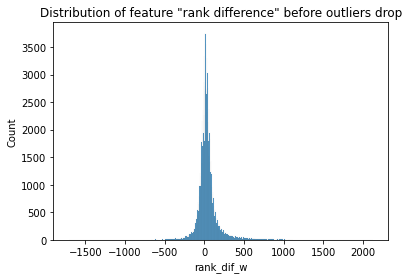

In [15]:
# Check and drop outliers in feature "rank_dif" because range and SD are huge
sns.histplot((data_rank_row['rank_dif_w']))
plt.title('Distribution of feature "rank difference" before outliers drop')

out, data_rank = outliers_z_score_mod(
    data=data_rank_row, 
    feature='rank_dif_w'
)
print(f'Number of outliers {out.shape[0]}\n\
Percent of outliers {round(out.shape[0] / data_rank.shape[0] * 100, 2)}%')

In [16]:
# Aggregate by winners:
#   -general number of winnings
#   -number of winnings when winner's rank was higher more than 20
winners = sql(""" 
    SELECT
        name,
        COUNT(match_num) AS win,
        SUM(rank_diff_20_w) AS win_rank_20
    FROM data_rank
    JOIN players ON winner_name = name 
    GROUP BY name
""")

# Aggregate by losers:
#   -general number of losses
#   -number of losses when loser's rank was higher more than 20
losers = sql(""" 
    SELECT
        name,
        COUNT(match_num) AS lose,
        SUM(rank_diff_20_l) AS lose_rank_20
    FROM data_rank
    JOIN players ON loser_name = name 
    GROUP BY name
""")

# Create dataset aggregated by winner
rank_df = winners.join(
    losers.set_index(['name']),
    on=['name'],
    how='inner'
)

# Calculate percent of winnings in games where
# winner's rank was more than 20 poin higher than loser's one
rank_df['win_percent_rank_20'] = (
    rank_df['win_rank_20']
    / (rank_df['win_rank_20'] + rank_df['lose_rank_20'])
) * 100
# Calculate percent of winnings in games where
# winner's rank was not more than 20 poin higher than loser's rank
rank_df['win_percent_rank_less_20'] = (
    (rank_df['win'] - rank_df['win_rank_20'])
    / (rank_df['win'] + rank_df['lose']
       - rank_df['win_rank_20'] - rank_df['lose_rank_20'])
) * 100

rank_df.head(3)

,name,win,win_rank_20,lose,lose_rank_20,win_percent_rank_20,win_percent_rank_less_20
0,Aaron Krickstein,375,251,251,104,70.704225,45.756458
2,Abdullah Maqdas,2,1,4,1,50.000000,25.000000
3,Adam Chadaj,1,0,1,0,NaN,50.000000


In [17]:
# Fill NA values with 0 because if we drop this cases we lose 
# information of games without rank differense more than 20
rank_df = rank_df.fillna(0)

##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is rejected because p<0.05 and plots indicate not normal distribution.

Shapiro Test for 1st feature: p = 5.876802269757122e-37
Shapiro Test for 2nd feature: p = 1.4757400940473603e-21


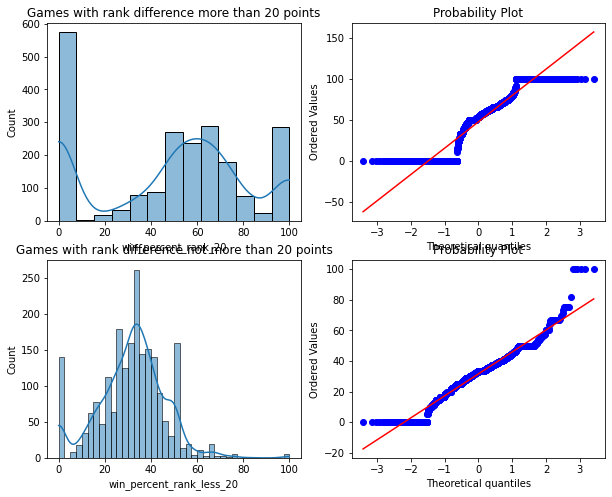

In [18]:
check_normality(
    feature1=rank_df['win_percent_rank_20'],
    feature2=rank_df['win_percent_rank_less_20'],
    title1='Games with rank difference more than 20 points',
    title2='Games with rank difference not more than 20 points'
)

##### Testing Hypothesis
- `H0`: if winner's rank is 20 points higher than loser's one mean winnings percent ***is not higher*** than that in case of winner's rank is not 20 points higher than loser's one  
- `H1`: if winner's rank is 20 points higher than loser's one mean winnings percent ***is higher*** than that in case of winner's rank is not 20 points higher than loser's one  
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- one-sided 'greater' H1  
- alpha = 0.05  

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.389e-97 U_stat=3.159e+06

Mann-Whitney test:
 H1 = greater, p = 3.389374026919046e-97


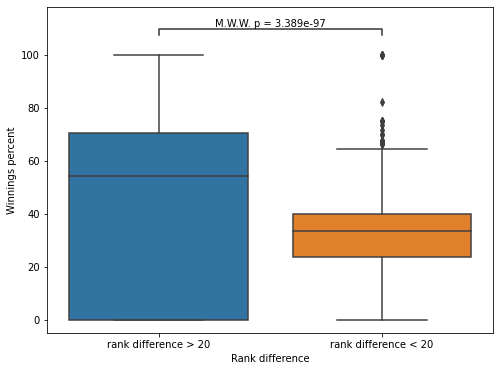

In [19]:
boxplot_stats(
    feature1=rank_df['win_percent_rank_20'],
    feature2=rank_df['win_percent_rank_less_20'],
    x_label1='rank difference > 20',
    x_label2='rank difference < 20',
    set_x='Rank difference',
    set_y='Winnings percent',
    alternative='greater'
)

**Conclusion:** H0 is rejected because p<0.05. This means that if player's rank is more than 20 points higher he has higher probability to win. This could be because of seeding system in tennis: the best players in a tournament won’t face each other in the earliest rounds.

##### б) Если ранг игрока находится в окне +-5 позиций, то вероятность победы будет значительно отличаться от гипотезы из предыдущего случая. Для проверки статистической значимости выборку можно сделать как среднее по годам (например, с 1980 по 2022г.). Подумайте, как правильно сформировать репрезентативную выборку. 

In [20]:
# Algorithm of data preprocessing is the same as in previous case 
# but for rank differense within +-5 points

winners_5 = sql(""" 
    SELECT
        name,
        COUNT(match_num) AS win,
        SUM(rank_diff_5) AS win_rank_5
    FROM data_rank
    JOIN players ON winner_name = name 
    GROUP BY name
""")

losers_5 = sql(""" 
    SELECT
        name,
        COUNT(match_num) AS lose,
        SUM(rank_diff_5) AS lose_rank_5
    FROM data_rank
    JOIN players ON loser_name = name 
    GROUP BY name
""")

rank_df_5 = winners_5.join(
    losers_5.set_index(['name']),
    on=['name'],
    how='inner'
)

rank_df_5['win_percent_rank_5'] = (
    rank_df_5['win_rank_5']
    / (rank_df_5['win_rank_5'] + rank_df_5['lose_rank_5'])
) * 100

rank_df_5['win_percent_rank_not_5'] = (
    (rank_df_5['win'] - rank_df_5['win_rank_5'])
    / (rank_df_5['win'] + rank_df_5['lose']
       - rank_df_5['win_rank_5'] - rank_df_5['lose_rank_5'])
) * 100

rank_df_5 = rank_df_5.fillna(0)

rank_df_5.head(3)

,name,win,win_rank_5,lose,lose_rank_5,win_percent_rank_5,win_percent_rank_not_5
0,Aaron Krickstein,375,20,251,17,54.054054,60.271647
2,Abdullah Maqdas,2,0,4,0,0.000000,33.333333
3,Adam Chadaj,1,0,1,0,0.000000,50.000000


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is rejected in case of 1st feature because p<0.05 and plots indicate not normal distribution, but can't be rejected in 2nd case. Anyway we perform non parametric test because we compare this two features.

Shapiro Test for 1st feature: p = 0.0
Shapiro Test for 2nd feature: p = 1.847369202057081e-10


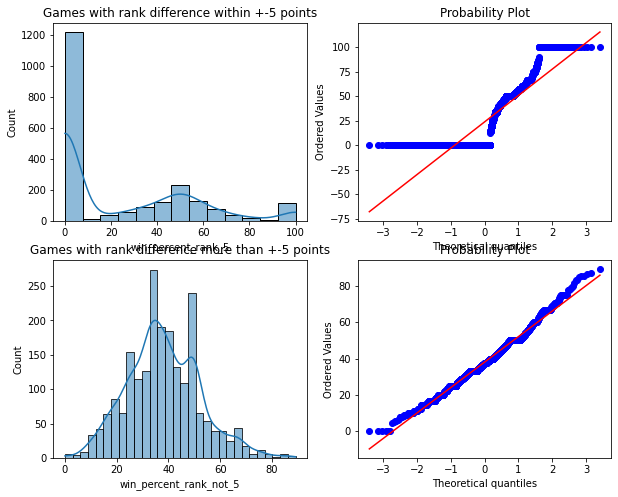

In [21]:
check_normality(
    feature1=rank_df_5['win_percent_rank_5'],
    feature2=rank_df_5['win_percent_rank_not_5'],
    title1='Games with rank difference within +-5 points',
    title2='Games with rank difference more than +-5 points'
)

##### Testing Hypothesis
- `H0`: if rank difference is within +-5 points mean winnings percent ***is not lower*** than that in case of bigger rank difference (more then 5 points in both sides)
- `H1`: if rank difference is within +-5 points mean winnings percent ***is lower*** than that in case of bigger rank difference (more then 5 points in both sides)  
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- one-sided 'less' H1  
- alpha = 0.05 

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.653e-95 U_stat=1.480e+06

Mann-Whitney test:
 H1 = less, p = 2.6532657738499374e-95


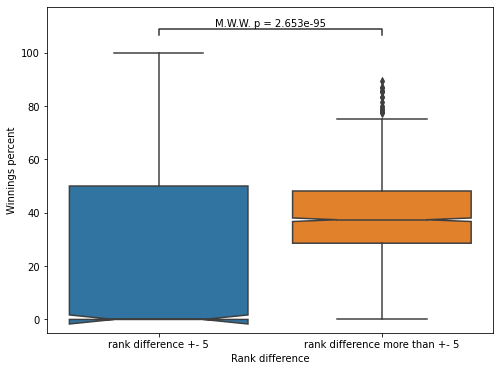

In [22]:
boxplot_stats(
    feature1=rank_df_5['win_percent_rank_5'],
    feature2=rank_df_5['win_percent_rank_not_5'],
    x_label1='rank difference +- 5',
    x_label2='rank difference more than +- 5',
    set_x='Rank difference',
    set_y='Winnings percent',
    alternative='less',
    notch=True
)

**Conclusion:** H0 is rejected because p<0.05. This means that if rank difference within +-5 points probability to win is even lower. This could be because small rank difference indicates equal level of players. Usually this occures between top players in final games when each player himself has highest probability to win.  

___
# Problem 2.
Правда ли, что среднее количество сетов, которое необходимо любому игроку для победы в матче, сокращается со временем? Разбейте данные на две группы — с 1980 до 2001 гг. и 2002-2022 гг. Как изменилось среднее количество сетов, которое победитель затратил на игру? Является ли разница средних этих двух выборок статистически значимой? Выбор статистического теста обоснуйте. 

In [23]:
# Drop NA values from target column
data_sets_row = data.dropna(subset=['score'])

# Count number of sets in each game
data_sets_row['sets_num'] = data_sets_row['score'].map(
    lambda x: len(x.split())
)

# Create binary feature dividing by two year periods
data_sets_row['before_2001'] = data_sets_row['year'].apply(
    lambda x: 1 if x <= 2001 else 0
)

# Aggregate mean number of sets by period and winner
data_sets = sql(""" 
    SELECT
        before_2001,
        winner_name,
        AVG(sets_num) AS sets_num_mean
    FROM data_sets_row
    GROUP BY before_2001, winner_name
""")
data_sets.head(3)

,before_2001,winner_name,sets_num_mean
0,0,Abd Hazli Bin Zainuddin,2.000000
1,0,Abdelhak Hameurlaine,2.000000
2,0,Abdullah Maqdas,3.090909


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is rejected because p<0.05 and plots indicate not normal distribution

Shapiro Test for 1st feature: p = 1.8359312729467747e-34
Shapiro Test for 2nd feature: p = 9.796828144828769e-28


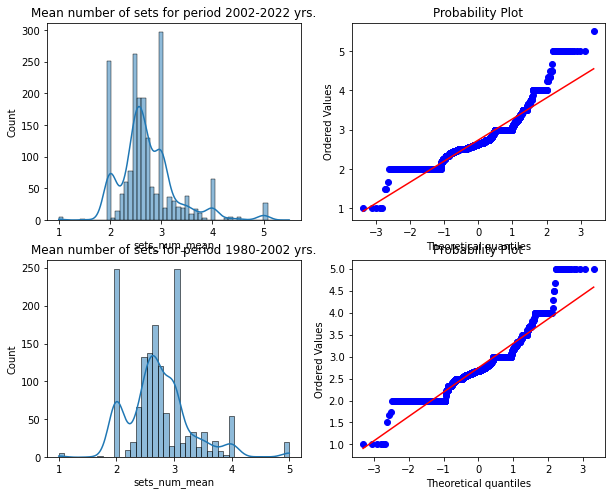

In [24]:
check_normality(
    feature1=data_sets[data_sets['before_2001'] == 1]['sets_num_mean'],
    feature2=data_sets[data_sets['before_2001'] == 0]['sets_num_mean'],
    title1='Mean number of sets for period 2002-2022 yrs.',
    title2='Mean number of sets for period 1980-2002 yrs.'
)

##### Testing Hypothesis
- `H0`: mean number of sets ***is equal*** in two periods (1980-2001 yrs. vs. 2002-2022 yrs.)
- `H1`: mean number of sets ***is higher*** in 1980-2001 yrs. than in 2002-2022 yrs. (i.e. decreasing during time)  
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- one-sided 'greater' H1  
- alpha = 0.05 

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:9.360e-01 U_stat=1.397e+06

Mann-Whitney test:
 H1 = greater, p = 0.9360497058904402


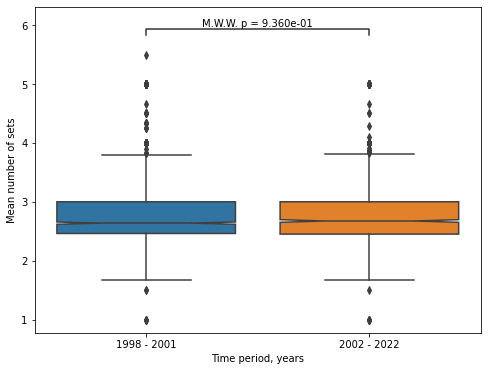

In [25]:
boxplot_stats(
    feature1=data_sets[data_sets['before_2001'] == 1]['sets_num_mean'],
    feature2=data_sets[data_sets['before_2001'] == 0]['sets_num_mean'],
    x_label1='1998 - 2001',
    x_label2='2002 - 2022',
    set_x='Time period, years',
    set_y='Mean number of sets',
    alternative='greater',
    notch=True
)

**Conclusion:** H0 is not rejected because p>0.05. The mean number of sets is equal in two periods (1980-2001 yrs. vs. 2002-2022 yrs.).  

___
### Problem 3. 
У вас появились сомнения — не является ли результат, который вы посчитали на предыдущем шаге, некорректным. Кажется, что на это мог повлиять формат самого матча — best of 3 или best of 5. Оставьте только матчи best of 5 (колонка best_of) и определите — является ли разница среднего количества сетов, которое сыграл победитель, значимой для выборок матчей по 1980 до 2001 гг. и 2002-2022 гг. Выбор статистического теста обоснуйте.

In [26]:
# Save only best of 5 mathes
data_best_5 = data[data['best_of'] == 5]

# Drop NA values from target column
data_best_5 = data_best_5.dropna(subset=['score'])

# Count number of sets in each game
data_best_5['sets_num'] = data_best_5['score'].map(
    lambda x: len(x.split())
)

# Create binary feature dividing by two year periods
data_best_5['before_2001'] = data_best_5['year'].apply(
    lambda x: 1 if x <= 2001 else 0
)

# Aggregate mean number of sets by period and winner
data_best_5 = sql(""" 
    SELECT
        before_2001,
        winner_name,
        AVG(sets_num) AS sets_num_mean
    FROM data_best_5
    GROUP BY before_2001, winner_name
""")
data_best_5.head(3)

,before_2001,winner_name,sets_num_mean
0,0,Abdullah Maqdas,3.571429
1,0,Adam Chadaj,3.000000
2,0,Adam Kellner,3.250000


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is rejected because p<0.05 and plots indicate not normal distribution

Shapiro Test for 1st feature: p = 2.232209789898371e-22
Shapiro Test for 2nd feature: p = 2.3624823744498776e-23


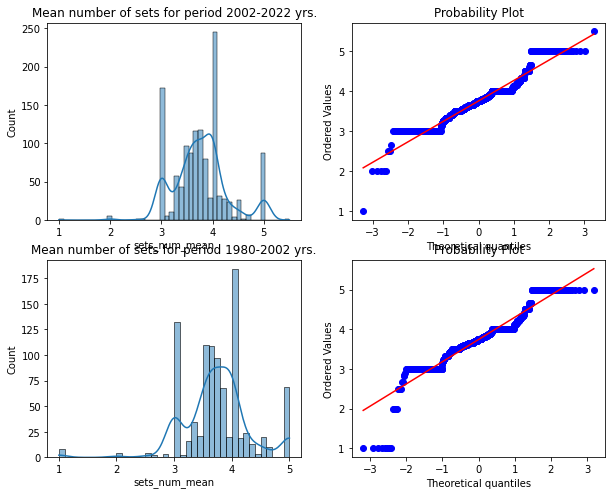

In [27]:
check_normality(
    feature1=data_best_5[data_best_5['before_2001'] == 1]['sets_num_mean'],
    feature2=data_best_5[data_best_5['before_2001'] == 0]['sets_num_mean'],
    title1='Mean number of sets for period 2002-2022 yrs.',
    title2='Mean number of sets for period 1980-2002 yrs.'
)

##### Testing Hypothesis
- `H0`: mean number of sets ***is equal*** in two periods (1980-2001 yrs. and 2002-2022 yrs.)
- `H1`: mean number of sets ***is higher*** in 1980-2001 yrs. than in 2002-2022 yrs. (i.e. decreasing during time)  
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- one-sided 'greater' H1  
- alpha = 0.05 

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:3.904e-01 U_stat=6.255e+05

Mann-Whitney test:
 H1 = greater, p = 0.3903817942485803


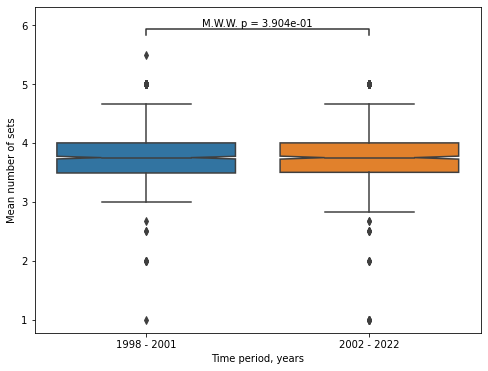

In [28]:
boxplot_stats(
    feature1=data_best_5[data_best_5['before_2001'] == 1]['sets_num_mean'],
    feature2=data_best_5[data_best_5['before_2001'] == 0]['sets_num_mean'],
    x_label1='1998 - 2001',
    x_label2='2002 - 2022',
    set_x='Time period, years',
    set_y='Mean number of sets',
    alternative='greater',
    notch=True
)

**Conclusion:** H0 is not rejected because p>0.05. The mean number of sets is equal in diferent periods as in previous case (problem 2). This also indicates that game type (best of 3 or best of 5) doesn't influence on probable changing of sets number during time.

___
### Problem 4.
Вы хотите изучить психологическую устойчивость профессиональных игроков в теннис. Одним из важных показателей такой устойчивости будет доля выигранных брейк-поинтов. Возьмите трех игроков (они необязательно должны играть в одно и то же время. Можете взять игроков, которые сильно отличаются по рангу, а можете взять примерно равных игроков), для каждого из них посчитайте долю выигранных брейк поинтов (колонки, заканчивающиеся на bpFaced и bpSaved) отдельно в победных и проигранных матчах за минимум 10 лет (можно больше, но годы должны идти подряд). Постройте box-plot’ы для этих статистик для каждого из игроков. Являются ли эти распределения по годам (по победным и по проигранным матчам) независимыми для каждого из игроков? Если сравнивать эту статистику между игроками — будет ли разница в средних для проигранных и выигранных матчей значимой попарно между всеми игроками? Выбор статистического теста обоснуйте.

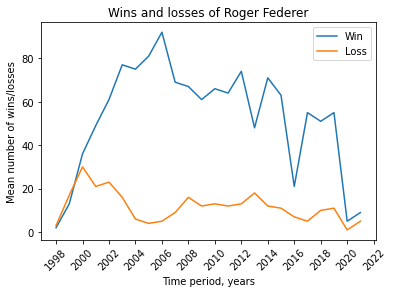

In [29]:
# Collect statistics on wins and losses of Roger Federer
roger_win, roger_loss = win_loss_prep(
    data=data, 
    name='Roger Federer'
)

In [30]:
# Calculate statistics on winning breakpoints on 11 year period
roger_df = win_loss_modif(
    df_win=roger_win,
    df_loss=roger_loss,
    y_low=2003,
    y_up=2014
)
roger_df.head(3)

,bpSaved,bpFaced,win,win_bp_perc
0,169.0,239.0,1,70.711297
1,182.0,245.0,1,74.285714
2,190.0,278.0,1,68.345324


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is not rejected because p>0.05. But groups are small (11 cases) so we use non parametric test.

Shapiro Test for 1st feature: p = 0.7962248921394348
Shapiro Test for 2nd feature: p = 0.03383009880781174


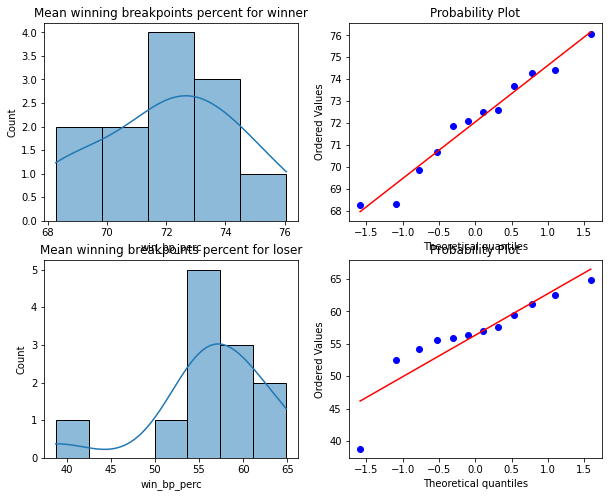

In [31]:
check_normality(
    feature1=roger_df[roger_df['win'] == 1]['win_bp_perc'],
    feature2=roger_df[roger_df['win'] == 0]['win_bp_perc'],
    title1="Mean winning breakpoints percent for winner",
    title2="Mean winning breakpoints percent for loser"
)

##### Testing Hypothesis
- `H0`: mean number of winning breakpoints ***is equal*** both in wining and losing games
- `H1`: mean number of winning breakpoints ***is higher*** in wining games than in losing ones  
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- one-sided 'greater' H1  
- alpha = 0.05  
- parameters are independent because encoded by grouping variable events are mutually exclusive. 

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:1.829e-05 U_stat=1.440e+02

Mann-Whitney test:
 H1 = greater, p = 1.82922767694855e-05


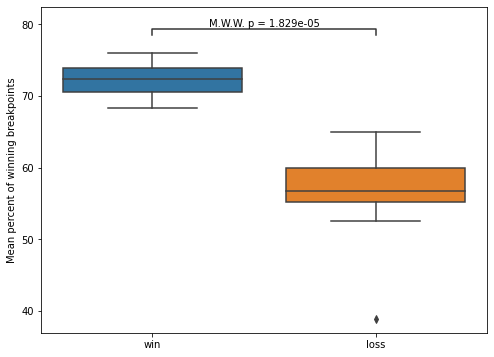

In [32]:
boxplot_stats(
    feature1=roger_df[roger_df['win'] == 1]['win_bp_perc'],
    feature2=roger_df[roger_df['win'] == 0]['win_bp_perc'],
    x_label1='win',
    x_label2='loss',
    set_x='',
    set_y='Mean percent of winning breakpoints',
    alternative='greater'
)

**Conclusion:** H0 is rejected because p<0.05. Mean number of winning breakpoints is higher in wining games than in losing ones. This means that the more breakpoints have been won in the game the higher probability to win this game.

___

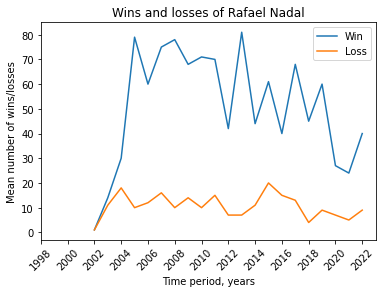

In [33]:
# Collect statistics on wins and losses of Rafael Nadal
nadal_win, nadal_loss = win_loss_prep(
    data=data, 
    name='Rafael Nadal'
)

In [34]:
# Calculate statistics on winning breakpoints on 11 year period
nadal_df = win_loss_modif(
    df_win=nadal_win,
    df_loss=nadal_loss,
    y_low=2005,
    y_up=2016
)
nadal_df.head(3)

,bpSaved,bpFaced,win,win_bp_perc
0,229.0,345.0,1,66.376812
1,192.0,272.0,1,70.588235
2,222.0,312.0,1,71.153846


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is not rejected because p>0.05. But groups are small (11 cases) so we use non parametric tests

Shapiro Test for 1st feature: p = 0.65276038646698
Shapiro Test for 2nd feature: p = 0.19699479639530182


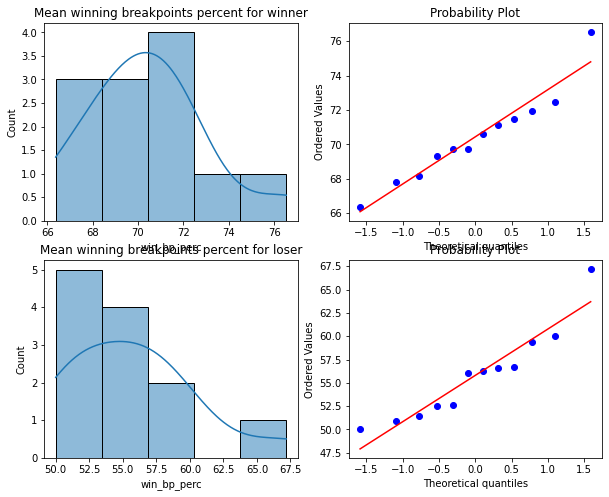

In [35]:
check_normality(
    feature1=nadal_df[nadal_df['win'] == 1]['win_bp_perc'],
    feature2=nadal_df[nadal_df['win'] == 0]['win_bp_perc'],
    title1="Mean winning breakpoints percent for winner",
    title2="Mean winning breakpoints percent for loser"
)

##### Testing Hypothesis
Hypothesis is the same as in previous case.  
The previous result (as with Roger Federer) is confirmed.

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.347e-05 U_stat=1.430e+02

Mann-Whitney test:
 H1 = greater, p = 2.3474362824769387e-05


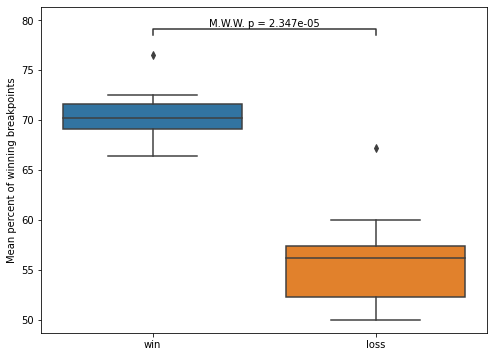

In [36]:
boxplot_stats(
    feature1=nadal_df[nadal_df['win'] == 1]['win_bp_perc'],
    feature2=nadal_df[nadal_df['win'] == 0]['win_bp_perc'],
    x_label1='win',
    x_label2='loss',
    set_x='',
    set_y='Mean percent of winning breakpoints',
    alternative='greater'
)

___

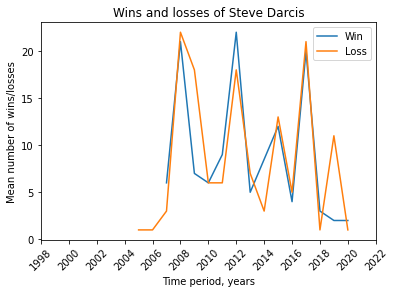

In [37]:
# Collect statistics on wins and losses of Steve Darcis
steve_win, steve_loss = win_loss_prep(
    data=data, 
    name='Steve Darcis'
)

In [38]:
# Calculate statistics on winning breakpoints on 11 year period
steve_df = win_loss_modif(
    df_win=steve_win,
    df_loss=steve_loss,
    y_low=2007,
    y_up=2018
)
steve_df.head(3)

,bpSaved,bpFaced,win,win_bp_perc
0,24.0,36.0,1,66.666667
1,58.0,83.0,1,69.879518
2,5.0,6.0,1,83.333333


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is not rejected because p>0.05. But groups are small (11 cases) so we use non parametric tests

Shapiro Test for 1st feature: p = 0.5765121579170227
Shapiro Test for 2nd feature: p = 0.4165716767311096


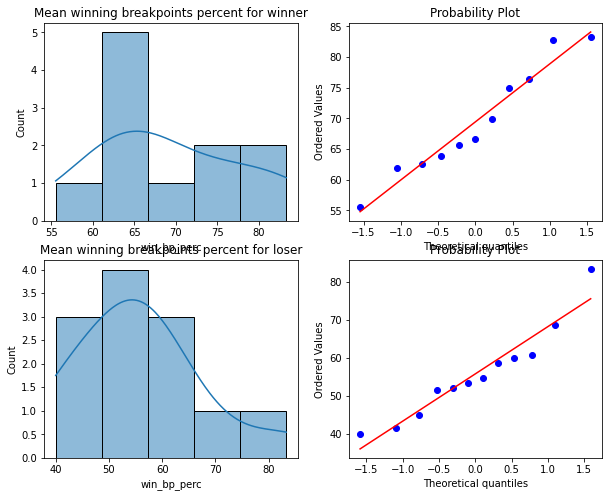

In [39]:
check_normality(
    feature1=steve_df[steve_df['win'] == 1]['win_bp_perc'],
    feature2=steve_df[steve_df['win'] == 0]['win_bp_perc'],
    title1="Mean winning breakpoints percent for winner",
    title2="Mean winning breakpoints percent for loser"
)

##### Testing Hypothesis
Hypothesis is the same as in previous cases.  
The same result is confirmed despite this player has much lower rank than previous ones. Howewer the difference in this case seems to be a bit smaller (likely because number of wining games of Steve Darcis is lower).

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:2.314e-03 U_stat=1.125e+02

Mann-Whitney test:
 H1 = greater, p = 0.0023143110356062292


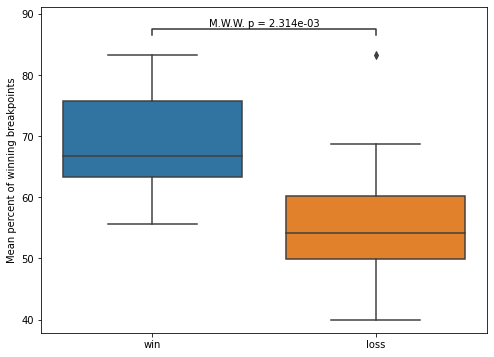

In [40]:
boxplot_stats(
    feature1=steve_df[steve_df['win'] == 1]['win_bp_perc'],
    feature2=steve_df[steve_df['win'] == 0]['win_bp_perc'],
    x_label1='win',
    x_label2='loss',
    set_x='',
    set_y='Mean percent of winning breakpoints',
    alternative='greater'
)

___

##### Testing Hypothesis
- `H0`: mean number of winning breakpoints ***is equal*** between players (separetely in wins and losses)
- `H1`: mean number of winning breakpoints ***is not equal*** between players (separetely in wins and losses) 
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- two-sided H1  
- alpha = 0.05  

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1_nadal vs. 1_steve: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=7.900e+01
0_roger vs. 0_nadal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.600e+01
0_nadal vs. 0_steve: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=7.350e+01
1_roger vs. 1_nadal: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:4.138e-01 U_stat=1.040e+02
1_roger vs. 1_steve: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.200e+01
0_roger vs. 0_steve: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val:1.000e+00 U_stat=8.400e+01


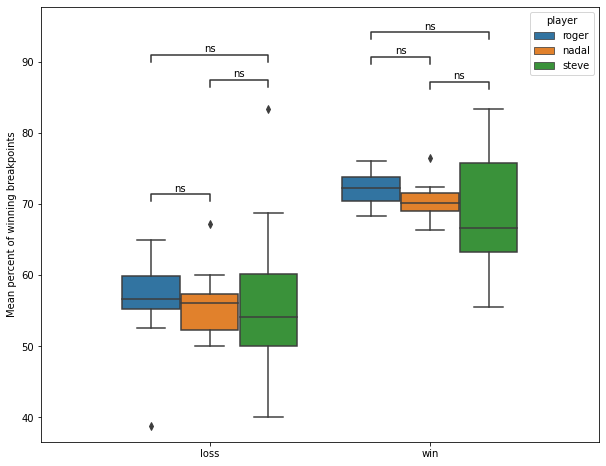

In [41]:
roger_df['player'] = 'roger'
nadal_df['player'] = 'nadal'
steve_df['player'] = 'steve'
df = pd.concat([roger_df, nadal_df, steve_df], ignore_index=True)

x = 'win'
y = 'win_bp_perc'
hue = 'player'
pairs = [
    ((0.0, 'roger'), (0.0, 'nadal')),
    ((0.0, 'roger'), (0.0, 'steve')),
    ((0.0, 'steve'), (0.0, 'nadal')),
    ((1.0, 'roger'), (1.0, 'nadal')),
    ((1.0, 'roger'), (1.0, 'steve')),
    ((1.0, 'steve'), (1.0, 'nadal'))
]

plt.figure(figsize=(10, 8))
ax = sns.boxplot(data=df, y=y, hue=hue, x=x)
ax.set_xlabel('')
ax.set_ylabel('Mean percent of winning breakpoints')
ax.set_xticklabels(['loss', 'win'])
annotator = Annotator(ax, pairs, data=df, y=y, hue=hue, x=x)
annotator.configure(test='Mann-Whitney', loc='inside',comparisons_correction="Bonferroni")
annotator.apply_and_annotate();

**Conclusion:** H0 is not rejected because p>0.05. Mean number of winning breakpoints is not differ between different players both in wins and losses.  
It's noted that ranges of percent of winning breakpoints are wider in case of Steve Darcis. It could be related to unstable performance in games.

___
### Problem 5
У вас есть гипотеза, что доля выигранных брейк-поинтов связана с вероятностью победить в игре. Соберите статистику, где для каждого матча будет собран его исход (победа/поражение) и доля выигранных брейк-поинтов (не забудьте, что в матче два игрока). Разделите долю выигранных брейкпоинтов на группы выше/ниже медианы и, используя информацию о исходе матча, проверьте зависимость между количеством выигранных брейкпоинтов и результатом матча. Насколько сильна эта зависимость? Выбор статистического теста обоснуйте.

In [42]:
# Drop NA values from target columns
data_bp = data.dropna(
    subset=['w_bpSaved', 'w_bpFaced', 'l_bpSaved', 'l_bpFaced']
)
data_bp = data_bp[data_bp['l_bpSaved'] > 0]

# Calculate percent of winning break points in winning ang losing games
bp_win = pd.concat([
    (data_bp["w_bpSaved"] / data_bp["w_bpFaced"] * 100)
    .reset_index(drop=True),
    pd.Series(np.ones_like(data_bp["w_bpSaved"]), name="game_win_lose")
], axis=1).rename(columns={0: "bp_win"})

bp_loss = pd.concat([
    (data_bp["l_bpSaved"] / data_bp["l_bpFaced"] * 100)
    .reset_index(drop=True),
    pd.Series(np.zeros_like(data_bp["l_bpSaved"]), name="game_win_lose")
], axis=1).rename(columns={0: "bp_win"})

# Concatinate win and loss data and drop NA values
bp_game = pd.concat([bp_win, bp_loss])
bp_game = bp_game.dropna()
bp_game.head()

,bp_win,game_win_lose
0,50.0,1.0
1,90.0,1.0
2,100.0,1.0
3,100.0,1.0
4,87.5,1.0


##### Check for [normality](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)
`H0`: distribution ~N(mu, sigma)  
`H1`: distribution not ~N(mu, sigma)  
alpha = 0.05  
`H0` is rejected because p<0.05 and plots indicate not normal distribution.

Shapiro Test for 1st feature: p = 0.0
Shapiro Test for 2nd feature: p = 0.0


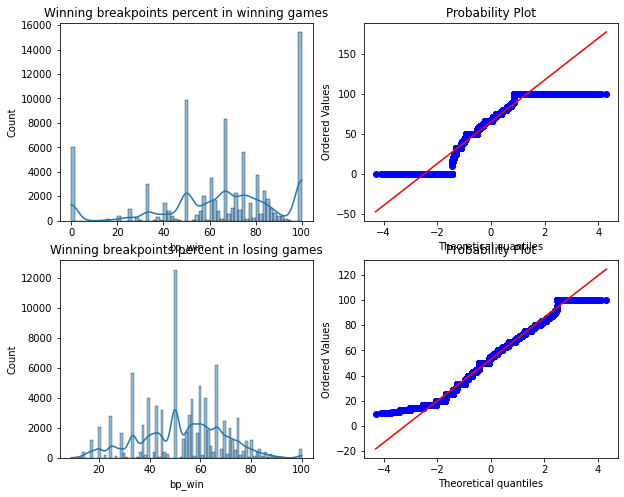

In [43]:
check_normality(
    feature1=bp_game[bp_game['game_win_lose'] == 1]['bp_win'],
    feature2=bp_game[bp_game['game_win_lose'] == 0]['bp_win'],
    title1="Winning breakpoints percent in winning games",
    title2="Winning breakpoints percent in losing games"
)

##### Testing Hypothesis
- `H0`: mean number of winning breakpoints ***is equal*** between winning ang losing games
- `H1`: mean number of winning breakpoints ***is higher*** in winning games than in losing ones 
- Test: [Mann-Whitney](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html), [visualizing](https://github.com/trevismd/statannotations)  
- one-sided 'greater' H1  
- alpha = 0.05 

0 vs. 1: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=4.782e+09

Mann-Whitney test:
 H1 = greater, p = 0.0


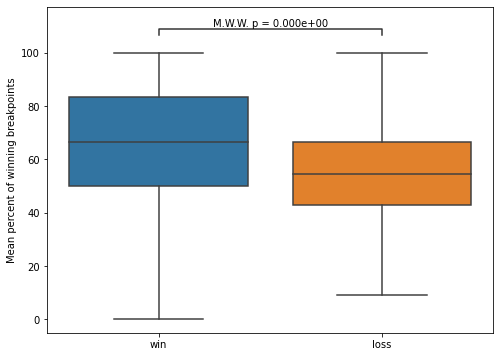

In [44]:
boxplot_stats(
    feature1=bp_game[bp_game['game_win_lose'] == 1]['bp_win'],
    feature2=bp_game[bp_game['game_win_lose'] == 0]['bp_win'],
    x_label1='win',
    x_label2='loss',
    set_x='',
    set_y='Mean percent of winning breakpoints',
    alternative='greater'
)

**Conclusion:** H0 is rejected because p<0.05. Mean number of winning breakpoints is higher in winning games than in losing ones (the same as with individual data - Problem 4 above). This probably means that the more breakpoints have been won in the game the higher probability to win this game. 

In [45]:
# Create binary feature 
# whether percent of wining breakpoints is higher the median or not
bp_median = bp_game['bp_win'].median()
bp_game['bp_higher_median'] = bp_game['bp_win'].apply(
    lambda x: 1 if x >= bp_median else 0
)
bp_game.head(3)

,bp_win,game_win_lose,bp_higher_median
0,50.0,1.0,0
1,90.0,1.0,1
2,100.0,1.0,1


In [46]:
pd.crosstab(
    bp_game['game_win_lose'].astype(bool), 
    bp_game['bp_higher_median'].astype(bool)
)

bp_higher_median,False,True
game_win_lose,,
False,53464,34047
True,27220,52820


##### Testing Hypothesis
- `H0`: number of winning and losing breakpoints ***is equal*** between winning ang losing games
- `H1`: number of winning breakpoints ***is not equal*** between winning ang losing games 
- Test: [Chi-square](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html), [mosaic plot](https://www.statsmodels.org/dev/generated/statsmodels.graphics.mosaicplot.mosaic.html)  
- alpha = 0.05 

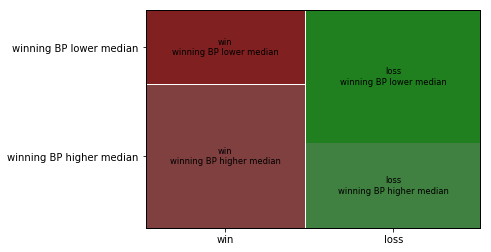

Phi and Cramer's V = 0.271


In [47]:
# Plot ratio of wins, losses and winning breakpoints
df_dict = {
    ('win', 'winning BP higher median'): 52820, 
    ('win', 'winning BP lower median'): 27220, 
    ('loss', 'winning BP higher median'): 34047, 
    ('loss', 'winning BP lower median'): 53464
}
mosaic(df_dict)  
plt.show()

# Calculate statistics
chisq_stats = stats.chi2_contingency(
    pd.crosstab(bp_game['game_win_lose'].astype(bool), 
                bp_game['bp_higher_median'].astype(bool)), 
    correction=False
)[0]
n = np.sum(
    pd.crosstab(bp_game['game_win_lose'].astype(bool), 
                bp_game['bp_higher_median'].astype(bool))
)
n = n.sum()
minshape = (
    min(
        pd.crosstab(bp_game['game_win_lose'].astype(bool), 
                    bp_game['bp_higher_median'].astype(bool))
    .shape) 
    - 1
)
cramer = np.sqrt((chisq_stats / n) / minshape)
print(f"Phi and Cramer's V = {round(cramer, 3)}")

**Conclusion:** H0 is rejected because p<0.05. Number of winning and losing breakpoints is not equal in winning and losing games. As we can see at mosaic plot the number of winning breakpoints is much higher than median in wining games. Vise versa the number of losing breakpoints is much higher than median in losing games. Differences  power is very strong according to Cramer's rule.  
So our previous results are confirmed. The more breakpoints have been won in the game the higher probability to win this game. 